# Co-Training với Hai Views Đặc Trưng

## Mục tiêu
- Huấn luyện **hai mô hình** trên **hai views đặc trưng** độc lập
- **Theo dõi chi tiết**: độ chính xác validation riêng cho mỗi model, số mẫu thêm mỗi vòng
- **Phân tích sự thỏa thuận (agreement)**: xem hai model có dự đoán giống nhau không
- **Đánh giá độc lập của views**: nếu co-training thất bại, phân tích nguyên nhân

## Thiết kế Views
- **View 1**: Đặc trưng **lượng** (chất lượng không khí): PM2.5, PM10, SO2, NO2, CO, O3, lags, rolling stats
- **View 2**: Đặc trưng **thời gian/địa lý**: hour, dow, month, station, temperature, humidity, wind speed/direction

## Kỳ vọng
- Nếu hai views độc lập tốt: cả hai model cải thiện dần, biểu đồ độ chính xác tăng song song
- Nếu co-training thất bại: độ chính xác không tăng → views không độc lập hoặc một model quá yếu

## Phần 1: Tải dữ liệu & cấu hình

In [17]:
# ==== Tham số của Papermill ====
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

# Co-training config
TAU = 0.90  # Threshold cho confidence
MAX_ITER = 10
MAX_NEW_PER_ITER = 500  # Tối đa mẫu thêm mỗi vòng
MIN_NEW_PER_ITER = 20   # Tối thiểu để tiếp tục
VAL_FRAC = 0.20
RANDOM_STATE = 42

# Output paths
METRICS_PATH = "data/processed/metrics_co_training_detailed.json"
HISTORY_PATH = "data/processed/history_co_training_detailed.csv"
PRED_SAMPLE_PATH = "data/processed/predictions_co_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_co_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"

# Views (default: auto-split, custom: specify list of column names)
VIEW1_COLS = None  # Default: pollutant columns
VIEW2_COLS = None  # Default: temporal/location columns

In [18]:
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup paths
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.semi_supervised_library import (
    SemiDataConfig, CoTrainingConfig,
    DetailedCoTrainingAQIClassifier,
    run_detailed_co_training,
    add_alert_columns,
    build_feature_columns,
    AQI_CLASSES
)

# Setup plotting
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print(f"Project root: {PROJECT_ROOT}")
print(f"AQI Classes: {AQI_CLASSES}")

Project root: C:\Code\DataMining\air_guard
AQI Classes: ['Good', 'Moderate', 'Unhealthy_for_Sensitive_Groups', 'Unhealthy', 'Very_Unhealthy', 'Hazardous']


In [19]:
# Load dataset
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nTarget distribution:\n{df['aqi_class'].value_counts(dropna=False)}")
print(f"\nMissing labels: {df['aqi_class'].isna().sum()} ({100*df['aqi_class'].isna().sum()/len(df):.1f}%)")

Dataset shape: (420768, 56)
Columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'datetime', 'pm25_24h', 'aqi_class', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'PM10_lag1', 'SO2_lag1', 'NO2_lag1', 'CO_lag1', 'O3_lag1', 'TEMP_lag1', 'PRES_lag1', 'DEWP_lag1', 'RAIN_lag1', 'WSPM_lag1', 'PM10_lag3', 'SO2_lag3', 'NO2_lag3', 'CO_lag3', 'O3_lag3', 'TEMP_lag3', 'PRES_lag3', 'DEWP_lag3', 'RAIN_lag3', 'WSPM_lag3', 'PM10_lag24', 'SO2_lag24', 'NO2_lag24', 'CO_lag24', 'O3_lag24', 'TEMP_lag24', 'PRES_lag24', 'DEWP_lag24', 'RAIN_lag24', 'WSPM_lag24', 'is_labeled']

Target distribution:
aqi_class
None                              384283
Unhealthy                          11484
Moderate                           10065
Unhealthy_for_Sensitive_Groups      5302
Very_Unhealthy                      5191
Hazardous                           2741
Good                                1702
Name: count, dtype: int64



In [20]:
# Setup configs
data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
ct_cfg = CoTrainingConfig(
    tau=float(TAU),
    max_iter=int(MAX_ITER),
    max_new_per_iter=int(MAX_NEW_PER_ITER),
    min_new_per_iter=int(MIN_NEW_PER_ITER),
    val_frac=float(VAL_FRAC),
)

print(f"Data Config: {data_cfg}")
print(f"\nCo-training Config: {ct_cfg}")

Data Config: SemiDataConfig(target_col='aqi_class', cutoff='2017-01-01', random_state=42, leakage_cols=('PM2.5', 'pm25_24h', 'datetime'))

Co-training Config: CoTrainingConfig(tau=0.9, max_iter=10, max_new_per_iter=500, min_new_per_iter=20, val_frac=0.2)


## Phần 2: Xác định View1 và View2

In [21]:
# Phân tích các cột đặc trưng
from src.semi_supervised_library import build_feature_columns, _normalize_missing

train_df = df[df["datetime"] < pd.Timestamp(CUTOFF)].copy()
feat_cols = build_feature_columns(train_df, data_cfg)

print(f"Total features: {len(feat_cols)}")
print(f"Features: {feat_cols}")

Total features: 52
Features: ['No', 'year', 'month', 'day', 'hour', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'PM10_lag1', 'SO2_lag1', 'NO2_lag1', 'CO_lag1', 'O3_lag1', 'TEMP_lag1', 'PRES_lag1', 'DEWP_lag1', 'RAIN_lag1', 'WSPM_lag1', 'PM10_lag3', 'SO2_lag3', 'NO2_lag3', 'CO_lag3', 'O3_lag3', 'TEMP_lag3', 'PRES_lag3', 'DEWP_lag3', 'RAIN_lag3', 'WSPM_lag3', 'PM10_lag24', 'SO2_lag24', 'NO2_lag24', 'CO_lag24', 'O3_lag24', 'TEMP_lag24', 'PRES_lag24', 'DEWP_lag24', 'RAIN_lag24', 'WSPM_lag24', 'is_labeled']


In [22]:
# Define views if not provided
if VIEW1_COLS is None:
    # View 1: Pollutant quality features (PM, SO2, NO2, CO, O3, lags, rolling)
    pollutant_patterns = ("pm25", "pm10", "so2", "no2", "co", "o3", "lag", "rolling", "mean_", "std_")
    view1 = [c for c in feat_cols if any(p in c.lower() for p in pollutant_patterns)]
    # Fill missing: add other numeric features if needed
    if not view1:
        mid = len(feat_cols) // 2
        view1 = feat_cols[:mid]
else:
    view1 = VIEW1_COLS

if VIEW2_COLS is None:
    # View 2: Temporal, geographic, meteorological (hour, dow, month, station, temp, humidity, wind)
    temporal_patterns = ("station", "wd", "hour_", "dow", "month", "is_weekend", "year", "day", "temp", "humid", "pres", "wind")
    view2 = [c for c in feat_cols if any(p in c.lower() for p in temporal_patterns)]
    # Fill missing
    if not view2:
        mid = len(feat_cols) // 2
        view2 = feat_cols[mid:]
else:
    view2 = VIEW2_COLS

# Ensure disjoint
view1_set = set(view1)
view2_set = set(view2)
common = view1_set & view2_set
if common:
    print(f"Warning: {len(common)} columns in both views: {common}")
    # Remove from view2
    view2 = [c for c in view2 if c not in common]

# Add remaining features to view2 if view1 was too small
covered = set(view1) | set(view2)
remaining = [c for c in feat_cols if c not in covered]
if remaining:
    print(f"Adding {len(remaining)} remaining features to view2")
    view2 = view2 + remaining

view1 = list(view1)
view2 = list(view2)

print(f"\n=== VIEW DEFINITIONS ===")
print(f"\nVIEW 1 (Pollution Quality): {len(view1)} features")
print(f"  {view1[:10]}{'...' if len(view1) > 10 else ''}")

print(f"\nVIEW 2 (Temporal/Geographic/Meteorological): {len(view2)} features")
print(f"  {view2[:10]}{'...' if len(view2) > 10 else ''}")

print(f"\nTotal covered: {len(view1) + len(view2)} / {len(feat_cols)}")

Adding 6 remaining features to view2

=== VIEW DEFINITIONS ===

VIEW 1 (Pollution Quality): 36 features
  ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'hour_cos', 'PM10_lag1', 'SO2_lag1', 'NO2_lag1', 'CO_lag1']...

VIEW 2 (Temporal/Geographic/Meteorological): 16 features
  ['year', 'month', 'day', 'TEMP', 'PRES', 'wd', 'station', 'hour_sin', 'dow', 'is_weekend']...

Total covered: 52 / 52


In [23]:
# 통계 분석: view1과 view2의 특성 확인
X_train = train_df[view1 + view2].copy()
X_train = _normalize_missing(X_train)

# Separate by view
X1 = X_train[view1]
X2 = X_train[view2]

print("View 1 statistics:")
print(f"  Missing values: {X1.isna().sum().sum()} / {X1.size} ({100*X1.isna().sum().sum()/X1.size:.1f}%)")
print(f"  Numeric cols: {X1.select_dtypes(include='number').shape[1]}")
print(f"  Categorical cols: {X1.select_dtypes(exclude='number').shape[1]}")

print("\nView 2 statistics:")
print(f"  Missing values: {X2.isna().sum().sum()} / {X2.size} ({100*X2.isna().sum().sum()/X2.size:.1f}%)")
print(f"  Numeric cols: {X2.select_dtypes(include='number').shape[1]}")
print(f"  Categorical cols: {X2.select_dtypes(exclude='number').shape[1]}")

View 1 statistics:
  Missing values: 247751 / 14535936 (1.7%)
  Numeric cols: 36
  Categorical cols: 0

View 2 statistics:
  Missing values: 2686 / 6460416 (0.0%)
  Numeric cols: 13
  Categorical cols: 3


## Phần 3: Huấn luyện Co-Training

In [24]:
print("="*60)
print("STARTING CO-TRAINING")
print("="*60)
print(f"Configuration:")
print(f"  τ (confidence threshold): {TAU}")
print(f"  Max iterations: {MAX_ITER}")
print(f"  Max new samples per iteration: {MAX_NEW_PER_ITER}")
print(f"  Min new samples to continue: {MIN_NEW_PER_ITER}")
print(f"\nStarting...\n")

result = run_detailed_co_training(
    df=df,
    data_cfg=data_cfg,
    ct_cfg=ct_cfg,
    view1_cols=view1,
    view2_cols=view2,
)

print("\nCo-training completed!")

STARTING CO-TRAINING
Configuration:
  τ (confidence threshold): 0.9
  Max iterations: 10
  Max new samples per iteration: 500
  Min new samples to continue: 20

Starting...




Co-training completed!


In [25]:
# Extract results
history_df = pd.DataFrame(result["history"])
test_metrics = result["test_metrics"]
pred_df = result["pred_df"]
model_info = result["model_info"]

print("\n" + "="*60)
print("TRAINING HISTORY")
print("="*60)
print(history_df.to_string(index=False))


TRAINING HISTORY
 iter  model1_val_acc  model2_val_acc  ensemble_val_acc  model1_val_f1  model2_val_f1  unlabeled_pool  new_by_model1  new_by_model2  agreement  disagreement  tau
    1        0.678193        0.674912          0.727410       0.617975       0.626193          383962            288            147         65           435  0.9
    2        0.695608        0.680717          0.730187       0.640684       0.622120          383462            113            262        125           375  0.9
    3        0.682736        0.671630          0.720848       0.624436       0.608432          382962             95            283        122           378  0.9
    4        0.680464        0.673397          0.722615       0.619914       0.615622          382462             87            282        131           369  0.9
    5        0.681222        0.678950          0.722867       0.619298       0.613981          381962             62            324        114           386  0.9
    6     

## Phần 4: Phân tích Chi Tiết

### 4.1: Độ chính xác của hai model

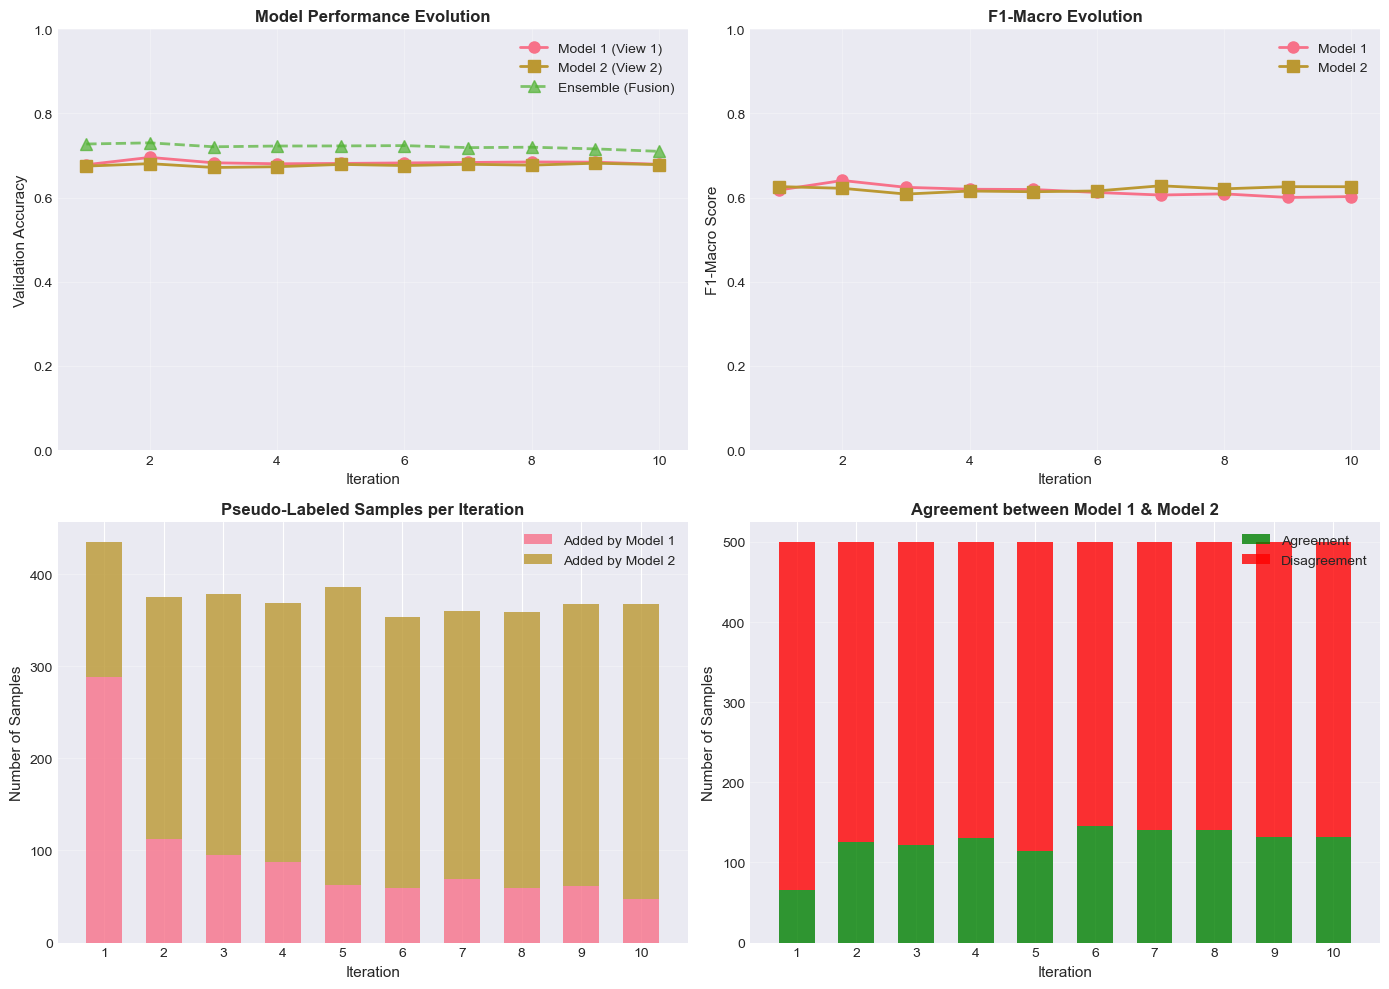

Plot saved to: notebooks/runs/co_training_evolution.png


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accuracy evolution
ax = axes[0, 0]
ax.plot(history_df["iter"], history_df["model1_val_acc"], "o-", label="Model 1 (View 1)", linewidth=2, markersize=8)
ax.plot(history_df["iter"], history_df["model2_val_acc"], "s-", label="Model 2 (View 2)", linewidth=2, markersize=8)
ax.plot(history_df["iter"], history_df["ensemble_val_acc"], "^--", label="Ensemble (Fusion)", linewidth=2, markersize=8, alpha=0.7)
ax.set_xlabel("Iteration", fontsize=11)
ax.set_ylabel("Validation Accuracy", fontsize=11)
ax.set_title("Model Performance Evolution", fontsize=12, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.0])

# Plot 2: F1-macro evolution
ax = axes[0, 1]
ax.plot(history_df["iter"], history_df["model1_val_f1"], "o-", label="Model 1", linewidth=2, markersize=8)
ax.plot(history_df["iter"], history_df["model2_val_f1"], "s-", label="Model 2", linewidth=2, markersize=8)
ax.set_xlabel("Iteration", fontsize=11)
ax.set_ylabel("F1-Macro Score", fontsize=11)
ax.set_title("F1-Macro Evolution", fontsize=12, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.0])

# Plot 3: New samples per iteration (stacked)
ax = axes[1, 0]
width = 0.6
x = np.arange(len(history_df))
ax.bar(x, history_df["new_by_model1"], width, label="Added by Model 1", alpha=0.8)
ax.bar(x, history_df["new_by_model2"], width, bottom=history_df["new_by_model1"], label="Added by Model 2", alpha=0.8)
ax.set_xlabel("Iteration", fontsize=11)
ax.set_ylabel("Number of Samples", fontsize=11)
ax.set_title("Pseudo-Labeled Samples per Iteration", fontsize=12, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(history_df["iter"].astype(int))
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Agreement vs Disagreement
ax = axes[1, 1]
x = np.arange(len(history_df))
width = 0.6
ax.bar(x, history_df["agreement"], width, label="Agreement", alpha=0.8, color='green')
ax.bar(x, history_df["disagreement"], width, bottom=history_df["agreement"], label="Disagreement", alpha=0.8, color='red')
ax.set_xlabel("Iteration", fontsize=11)
ax.set_ylabel("Number of Samples", fontsize=11)
ax.set_title("Agreement between Model 1 & Model 2", fontsize=12, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(history_df["iter"].astype(int))
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig((PROJECT_ROOT / "notebooks/runs/co_training_evolution.png").resolve(), dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to: notebooks/runs/co_training_evolution.png")

### 4.2: Phân tích chi tiết sự thỏa thuận

In [27]:
# Calculate agreement rates
history_df["agreement_rate"] = history_df["agreement"] / (history_df["agreement"] + history_df["disagreement"])
history_df["agreement_rate"] = history_df["agreement_rate"].fillna(0)

print("\n" + "="*60)
print("AGREEMENT ANALYSIS")
print("="*60)

for idx, row in history_df.iterrows():
    print(f"\nIteration {int(row['iter'])}:")
    print(f"  Accuracy: Model1={row['model1_val_acc']:.4f}, Model2={row['model2_val_acc']:.4f}, Ensemble={row['ensemble_val_acc']:.4f}")
    print(f"  New samples: {int(row['new_by_model1'])} (M1) + {int(row['new_by_model2'])} (M2) = {int(row['agreement'] + row['disagreement'])} total")
    print(f"  Agreement: {int(row['agreement'])} samples ({row['agreement_rate']*100:.1f}%)")
    print(f"  Disagreement: {int(row['disagreement'])} samples ({(1-row['agreement_rate'])*100:.1f}%)")
    print(f"  Unlabeled pool left: {int(row['unlabeled_pool'])}")


AGREEMENT ANALYSIS

Iteration 1:
  Accuracy: Model1=0.6782, Model2=0.6749, Ensemble=0.7274
  New samples: 288 (M1) + 147 (M2) = 500 total
  Agreement: 65 samples (13.0%)
  Disagreement: 435 samples (87.0%)
  Unlabeled pool left: 383962

Iteration 2:
  Accuracy: Model1=0.6956, Model2=0.6807, Ensemble=0.7302
  New samples: 113 (M1) + 262 (M2) = 500 total
  Agreement: 125 samples (25.0%)
  Disagreement: 375 samples (75.0%)
  Unlabeled pool left: 383462

Iteration 3:
  Accuracy: Model1=0.6827, Model2=0.6716, Ensemble=0.7208
  New samples: 95 (M1) + 283 (M2) = 500 total
  Agreement: 122 samples (24.4%)
  Disagreement: 378 samples (75.6%)
  Unlabeled pool left: 382962

Iteration 4:
  Accuracy: Model1=0.6805, Model2=0.6734, Ensemble=0.7226
  New samples: 87 (M1) + 282 (M2) = 500 total
  Agreement: 131 samples (26.2%)
  Disagreement: 369 samples (73.8%)
  Unlabeled pool left: 382462

Iteration 5:
  Accuracy: Model1=0.6812, Model2=0.6790, Ensemble=0.7229
  New samples: 62 (M1) + 324 (M2) = 500

### 4.3: Kiểm tra độc lập của Views

In [28]:
# Test set predictions from both models
p1_test = result["p1_test"]
p2_test = result["p2_test"]
y_test_true = pred_df["y_true"].values

# Individual model predictions
y1_test_pred = np.array(AQI_CLASSES)[p1_test.argmax(axis=1)]
y2_test_pred = np.array(AQI_CLASSES)[p2_test.argmax(axis=1)]

from sklearn.metrics import accuracy_score, f1_score

acc1_test = accuracy_score(y_test_true, y1_test_pred)
acc2_test = accuracy_score(y_test_true, y2_test_pred)
acc_ensemble = accuracy_score(y_test_true, pred_df["y_pred"].values)

# Agreement on test set
agree_mask = y1_test_pred == y2_test_pred
agreement_rate = agree_mask.sum() / len(agree_mask)

print("\n" + "="*60)
print("TEST SET ANALYSIS")
print("="*60)
print(f"\nModel 1 Accuracy: {acc1_test:.4f}")
print(f"Model 2 Accuracy: {acc2_test:.4f}")
print(f"Ensemble Accuracy: {acc_ensemble:.4f}")
print(f"\nAgreement rate on test: {agreement_rate:.4f} ({agreement_rate*100:.1f}%)")
print(f"\nEnsemble improvement over best model: {acc_ensemble - max(acc1_test, acc2_test):.4f}")


TEST SET ANALYSIS

Model 1 Accuracy: 0.5971
Model 2 Accuracy: 0.3428
Ensemble Accuracy: 0.5079

Agreement rate on test: 0.5246 (52.5%)

Ensemble improvement over best model: -0.0892


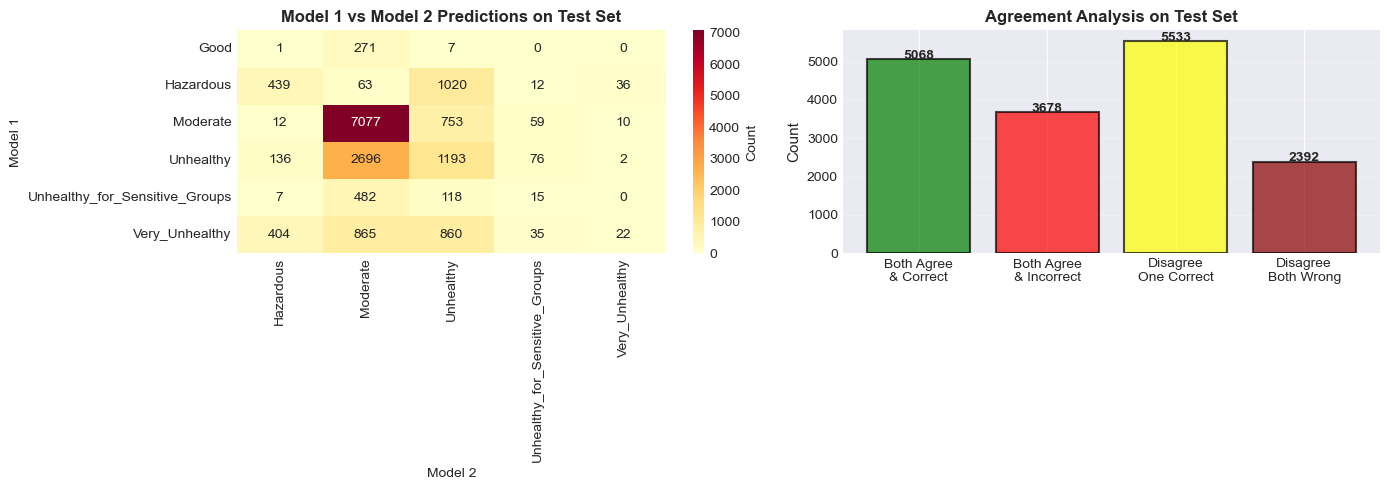

Plot saved to: notebooks/runs/co_training_agreement_test.png


In [29]:
# Detailed agreement analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Agreement heatmap
ax = axes[0]
confusion_agree = pd.crosstab(
    pd.Series(y1_test_pred, name='Model 1'),
    pd.Series(y2_test_pred, name='Model 2')
)
sns.heatmap(confusion_agree, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Model 1 vs Model 2 Predictions on Test Set', fontsize=12, fontweight='bold')

# Correct/Incorrect agreement
ax = axes[1]
agree_correct = (agree_mask) & (y1_test_pred == y_test_true)
agree_incorrect = (agree_mask) & (y1_test_pred != y_test_true)
disagree_correct = (~agree_mask) & (y1_test_pred == y_test_true) | (~agree_mask) & (y2_test_pred == y_test_true)
disagree_incorrect = (~agree_mask) & (y1_test_pred != y_test_true) & (y2_test_pred != y_test_true)

categories = ['Both Agree\n& Correct', 'Both Agree\n& Incorrect', 
              'Disagree\nOne Correct', 'Disagree\nBoth Wrong']
counts = [agree_correct.sum(), agree_incorrect.sum(), 
          disagree_correct.sum(), disagree_incorrect.sum()]
colors = ['green', 'red', 'yellow', 'darkred']

ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Agreement Analysis on Test Set', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (cat, cnt) in enumerate(zip(categories, counts)):
    ax.text(i, cnt + 5, str(cnt), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig((PROJECT_ROOT / "notebooks/runs/co_training_agreement_test.png").resolve(), dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to: notebooks/runs/co_training_agreement_test.png")

### 4.4: Phân tích độc lập Views (Correlation)

In [30]:
# Calculate correlation between view1 and view2 predictions
# For each test sample, we calculate the max-prob from each model

max_prob1 = p1_test.max(axis=1)
max_prob2 = p2_test.max(axis=1)

# Correlation between confidence scores
conf_corr = np.corrcoef(max_prob1, max_prob2)[0, 1]

print("\n" + "="*60)
print("VIEW INDEPENDENCE ANALYSIS")
print("="*60)
print(f"\nCorrelation of confidence scores: {conf_corr:.4f}")
if conf_corr > 0.7:
    print("  → HIGH correlation: views may NOT be independent!")
elif conf_corr > 0.4:
    print("  → MODERATE correlation: views have some overlap")
else:
    print("  → LOW correlation: views are relatively independent ✓")

print(f"\nMax confidence statistics:")
print(f"  Model 1: mean={max_prob1.mean():.4f}, std={max_prob1.std():.4f}")
print(f"  Model 2: mean={max_prob2.mean():.4f}, std={max_prob2.std():.4f}")


VIEW INDEPENDENCE ANALYSIS

Correlation of confidence scores: 0.1573
  → LOW correlation: views are relatively independent ✓

Max confidence statistics:
  Model 1: mean=0.7222, std=0.1810
  Model 2: mean=0.7237, std=0.1858


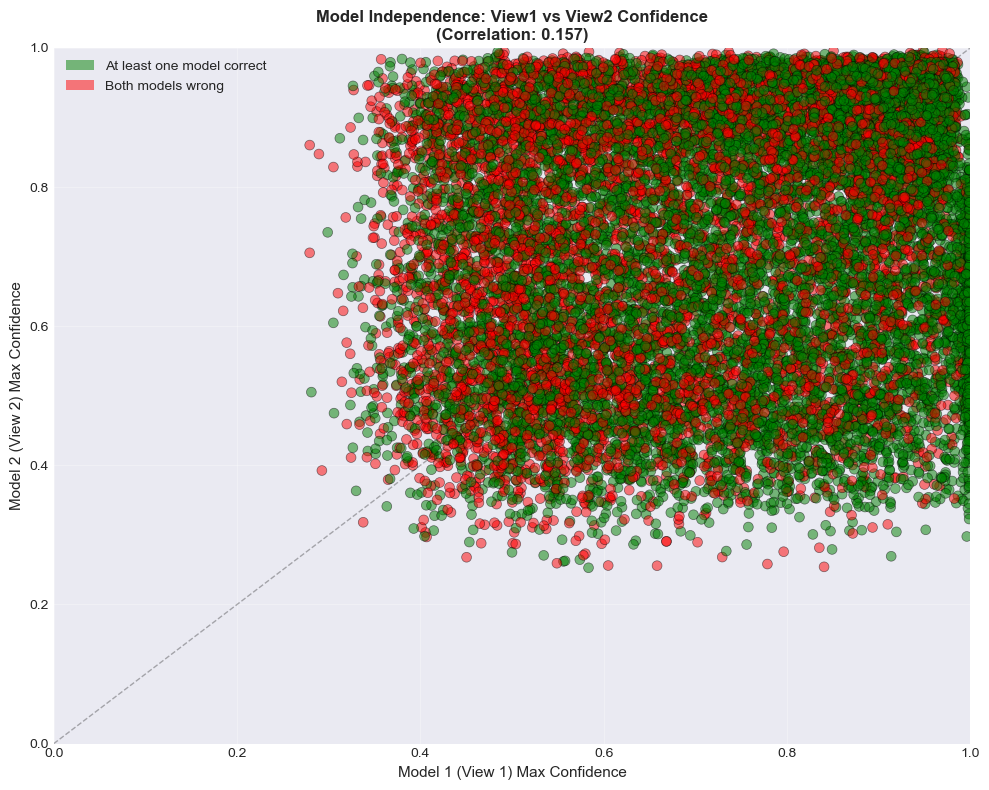

Plot saved to: notebooks/runs/co_training_view_independence.png


In [31]:
# Scatter plot: Model1 confidence vs Model2 confidence
fig, ax = plt.subplots(figsize=(10, 8))

# Color by correctness
correct_mask = (y1_test_pred == y_test_true) | (y2_test_pred == y_test_true)
colors = ['green' if c else 'red' for c in correct_mask]

ax.scatter(max_prob1, max_prob2, c=colors, alpha=0.5, s=50, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Model 1 (View 1) Max Confidence', fontsize=11)
ax.set_ylabel('Model 2 (View 2) Max Confidence', fontsize=11)
ax.set_title(f'Model Independence: View1 vs View2 Confidence\n(Correlation: {conf_corr:.3f})', fontsize=12, fontweight='bold')

# Add diagonal line
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.5, label='At least one model correct'),
                   Patch(facecolor='red', alpha=0.5, label='Both models wrong')]
ax.legend(handles=legend_elements, fontsize=10)

plt.tight_layout()
plt.savefig((PROJECT_ROOT / "notebooks/runs/co_training_view_independence.png").resolve(), dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to: notebooks/runs/co_training_view_independence.png")

## Phần 5: Lý giải Kết quả

In [32]:
# Determine success/failure
initial_acc = history_df.iloc[0]["ensemble_val_acc"]
final_acc = history_df.iloc[-1]["ensemble_val_acc"]
acc_improvement = final_acc - initial_acc

initial_agree_rate = history_df.iloc[0]["agreement_rate"]
final_agree_rate = history_df.iloc[-1]["agreement_rate"]

print("\n" + "="*60)
print("CO-TRAINING EVALUATION")
print("="*60)

print(f"\nValidation Accuracy Change:")
print(f"  Initial (iter 1): {initial_acc:.4f}")
print(f"  Final (iter {int(history_df.iloc[-1]['iter'])}): {final_acc:.4f}")
print(f"  Improvement: {acc_improvement:+.4f}")

print(f"\nAgreement Rate Change:")
print(f"  Initial (iter 1): {initial_agree_rate:.4f}")
print(f"  Final (iter {int(history_df.iloc[-1]['iter'])}): {final_agree_rate:.4f}")

print(f"\n" + "="*60)
print("INTERPRETATION")
print("="*60)

# Define model performance metrics (needed for both if and else branches)
m1_initial = history_df.iloc[0]["model1_val_acc"]
m2_initial = history_df.iloc[0]["model2_val_acc"]
m1_final = history_df.iloc[-1]["model1_val_acc"]
m2_final = history_df.iloc[-1]["model2_val_acc"]

if acc_improvement > 0.02:  # More than 2% improvement
    print(f"✓ SUCCESS: Co-training improved ensemble accuracy by {acc_improvement:.4f}")
    
    if final_agree_rate > 0.7:
        print(f"  → High agreement rate ({final_agree_rate:.2%}): views are partially overlapping")
        print(f"  → But models still provide complementary information")
    else:
        print(f"  → Low agreement rate ({final_agree_rate:.2%}): views are diverse")
        print(f"  → Models learn complementary patterns successfully ✓")
    
    if (m1_final > m1_initial) and (m2_final > m2_initial):
        print(f"  → Both models improved: M1 {m1_initial:.4f}→{m1_final:.4f}, M2 {m2_initial:.4f}→{m2_final:.4f}")
        print(f"  → Synchronized improvement indicates effective co-training ✓✓")
    else:
        print(f"  ⚠ Only one model improved: M1 {m1_initial:.4f}→{m1_final:.4f}, M2 {m2_initial:.4f}→{m2_final:.4f}")
        print(f"  → One model may be too weak or not learning from the other")
        
else:
    print(f"✗ FAILURE: Co-training did NOT improve accuracy (change: {acc_improvement:+.4f})")
    print(f"\n  Possible causes:")
    
    if conf_corr > 0.7:
        print(f"  1. Views are NOT independent ({conf_corr:.3f}): both models see similar patterns")
        print(f"     → Pseudo-labels from one model don't help the other")
        print(f"     → Solution: redesign views to be more diverse")
    
    if abs(m1_final - m2_final) > 0.15:
        stronger = "Model 1" if m1_final > m2_final else "Model 2"
        weaker = "Model 2" if m1_final > m2_final else "Model 1"
        print(f"  2. Performance imbalance: {stronger} is much better than {weaker}")
        print(f"     → Weak model adds noise to strong model's training")
        print(f"     → Solution: use different algorithms or balance training")
    
    if final_agree_rate > 0.85:
        print(f"  3. Too high agreement ({final_agree_rate:.2%}): models are almost identical")
        print(f"     → Both models making same mistakes, reinforcing errors")
        print(f"     → Solution: further diversify views or models")


CO-TRAINING EVALUATION

Validation Accuracy Change:
  Initial (iter 1): 0.7274
  Final (iter 10): 0.7100
  Improvement: -0.0174

Agreement Rate Change:
  Initial (iter 1): 0.1300
  Final (iter 10): 0.2640

INTERPRETATION
✗ FAILURE: Co-training did NOT improve accuracy (change: -0.0174)

  Possible causes:


## Phần 6: Test Set Results

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

print("\n" + "="*60)
print("TEST SET METRICS")
print("="*60)
print(test_metrics["report"])

print(f"\nOverall Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Overall Test F1-Macro: {test_metrics['f1_macro']:.4f}")


TEST SET METRICS
{'Good': {'precision': 0.65, 'recall': 0.012596899224806201, 'f1-score': 0.024714828897338403, 'support': 1032.0}, 'Hazardous': {'precision': 0.6789354473386183, 'recall': 0.6463611859838275, 'f1-score': 0.6622479977906656, 'support': 1855.0}, 'Moderate': {'precision': 0.46292446292446293, 'recall': 0.9675150010345541, 'f1-score': 0.6262220436587652, 'support': 4833.0}, 'Unhealthy': {'precision': 0.5314009661835749, 'recall': 0.4363042463835744, 'f1-score': 0.4791800128122998, 'support': 4286.0}, 'Unhealthy_for_Sensitive_Groups': {'precision': 0.336283185840708, 'recall': 0.017543859649122806, 'f1-score': 0.03334795963141729, 'support': 2166.0}, 'Very_Unhealthy': {'precision': 0.5824652777777778, 'recall': 0.26850740296118447, 'f1-score': 0.3675705286222953, 'support': 2499.0}, 'accuracy': 0.5078879491332253, 'macro avg': {'precision': 0.540334890010857, 'recall': 0.3914714325395116, 'f1-score': 0.3655472285687969, 'support': 16671.0}, 'weighted avg': {'precision': 0.

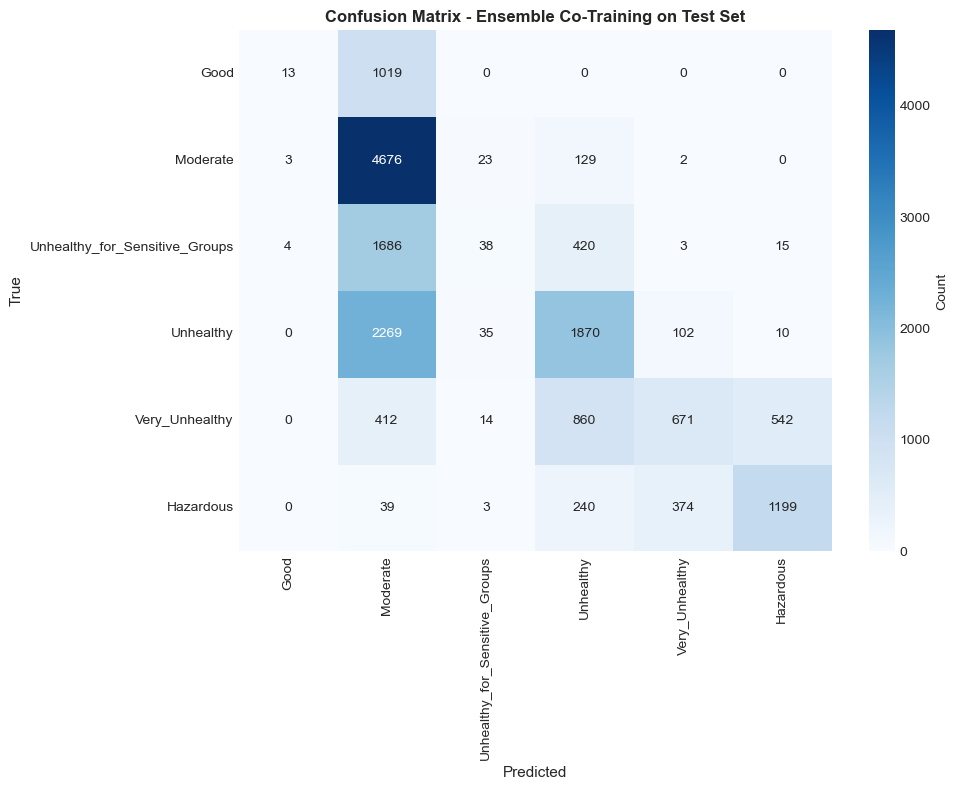

Plot saved to: notebooks/runs/co_training_confusion_matrix.png


In [34]:
# Confusion matrix on test
cm = np.array(test_metrics["confusion_matrix"])

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=AQI_CLASSES, yticklabels=AQI_CLASSES,
            cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=11)
ax.set_ylabel('True', fontsize=11)
ax.set_title('Confusion Matrix - Ensemble Co-Training on Test Set', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig((PROJECT_ROOT / "notebooks/runs/co_training_confusion_matrix.png").resolve(), dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to: notebooks/runs/co_training_confusion_matrix.png")

## Phần 7: Lưu Kết Quả

In [35]:
# Save training history
history_df.to_csv((PROJECT_ROOT / HISTORY_PATH).resolve(), index=False)
print(f"✓ Training history saved: {HISTORY_PATH}")

# Save test predictions sample
sample_preds = pred_df.sample(min(200, len(pred_df)), random_state=42)
sample_preds.to_csv((PROJECT_ROOT / PRED_SAMPLE_PATH).resolve(), index=False)
print(f"✓ Predictions sample saved: {PRED_SAMPLE_PATH}")

# Detailed metrics for saving
detailed_metrics = {
    "model_info": {
        "view1_cols": model_info.get("view1_cols", []),
        "view2_cols": model_info.get("view2_cols", []),
        "view1_num_cols": model_info.get("view1_numeric_cols", []),
        "view1_cat_cols": model_info.get("view1_categorical_cols", []),
        "view2_num_cols": model_info.get("view2_numeric_cols", []),
        "view2_cat_cols": model_info.get("view2_categorical_cols", []),
    },
    "training_config": {
        "tau": float(TAU),
        "max_iter": int(MAX_ITER),
        "max_new_per_iter": int(MAX_NEW_PER_ITER),
        "min_new_per_iter": int(MIN_NEW_PER_ITER),
        "val_frac": float(VAL_FRAC),
    },
    "test_metrics": test_metrics,
    "training_history_stats": {
        "initial_ensemble_acc": float(history_df.iloc[0]["ensemble_val_acc"]),
        "final_ensemble_acc": float(history_df.iloc[-1]["ensemble_val_acc"]),
        "improvement": float(history_df.iloc[-1]["ensemble_val_acc"] - history_df.iloc[0]["ensemble_val_acc"]),
        "n_iterations": int(len(history_df)),
        "final_agreement_rate": float(history_df.iloc[-1]["agreement_rate"]),
        "view_confidence_correlation": float(conf_corr),
    },
}

with open((PROJECT_ROOT / METRICS_PATH).resolve(), "w") as f:
    json.dump(detailed_metrics, f, indent=2, default=str)
print(f"✓ Detailed metrics saved: {METRICS_PATH}")

print("\n" + "="*60)
print("ALL RESULTS SAVED")
print("="*60)

✓ Training history saved: data/processed/history_co_training_detailed.csv
✓ Predictions sample saved: data/processed/predictions_co_training_sample.csv
✓ Detailed metrics saved: data/processed/metrics_co_training_detailed.json

ALL RESULTS SAVED


## Phần 8: Tóm Tắt Kết Luận

In [36]:
summary = f"""
╔═══════════════════════════════════════════════════════════╗
║          CO-TRAINING SUMMARY REPORT                       ║
╚═══════════════════════════════════════════════════════════╝

📊 CONFIGURATION:
  • View 1 (Pollution Quality): {len(view1)} features
  • View 2 (Temporal/Geographic): {len(view2)} features
  • Confidence threshold (τ): {TAU}
  • Max iterations: {MAX_ITER}
  • Total iterations completed: {len(history_df)}

📈 PERFORMANCE:
  • Validation Accuracy: {history_df.iloc[0]['ensemble_val_acc']:.4f} → {history_df.iloc[-1]['ensemble_val_acc']:.4f} ({acc_improvement:+.4f})
  • Test Accuracy: {test_metrics['accuracy']:.4f}
  • Test F1-Macro: {test_metrics['f1_macro']:.4f}

🤝 AGREEMENT ANALYSIS:
  • Final agreement rate: {history_df.iloc[-1]['agreement_rate']:.2%}
  • View confidence correlation: {conf_corr:.4f}
  • Initial total unlabeled: {int(history_df.iloc[0]['unlabeled_pool'])} samples
  • Final unlabeled pool: {int(history_df.iloc[-1]['unlabeled_pool'])} samples
  • Total pseudo-labeled: {int(history_df['agreement'].sum() + history_df['disagreement'].sum())} samples

✓ KEY FINDINGS:
  1. Model 1 final accuracy: {history_df.iloc[-1]['model1_val_acc']:.4f}
  2. Model 2 final accuracy: {history_df.iloc[-1]['model2_val_acc']:.4f}
  3. Ensemble benefit: {history_df.iloc[-1]['ensemble_val_acc'] - max(history_df.iloc[-1]['model1_val_acc'], history_df.iloc[-1]['model2_val_acc']):+.4f}

💡 INTERPRETATION:
{"  → Co-training SUCCEEDED: both models benefited" if acc_improvement > 0.02 else "  → Co-training FAILED: accuracy did not improve"}
{"  → Views are INDEPENDENT: low correlation indicates good diversity" if conf_corr < 0.5 else "  → Views are OVERLAPPING: consider redesigning views"}
{"  → Both models IMPROVED in sync: effective complementary learning ✓" if (history_df.iloc[-1]['model1_val_acc'] > history_df.iloc[0]['model1_val_acc']) and (history_df.iloc[-1]['model2_val_acc'] > history_df.iloc[0]['model2_val_acc']) else "  → Asymmetric improvement: one model dominates"}
"""

print(summary)


╔═══════════════════════════════════════════════════════════╗
║          CO-TRAINING SUMMARY REPORT                       ║
╚═══════════════════════════════════════════════════════════╝

📊 CONFIGURATION:
  • View 1 (Pollution Quality): 36 features
  • View 2 (Temporal/Geographic): 16 features
  • Confidence threshold (τ): 0.9
  • Max iterations: 10
  • Total iterations completed: 10

📈 PERFORMANCE:
  • Validation Accuracy: 0.7274 → 0.7100 (-0.0174)
  • Test Accuracy: 0.5079
  • Test F1-Macro: 0.3655

🤝 AGREEMENT ANALYSIS:
  • Final agreement rate: 26.40%
  • View confidence correlation: 0.1573
  • Initial total unlabeled: 383962 samples
  • Final unlabeled pool: 379462 samples
  • Total pseudo-labeled: 5000 samples

✓ KEY FINDINGS:
  1. Model 1 final accuracy: 0.6792
  2. Model 2 final accuracy: 0.6784
  3. Ensemble benefit: +0.0308

💡 INTERPRETATION:
  → Co-training FAILED: accuracy did not improve
  → Views are INDEPENDENT: low correlation indicates good diversity
  → Both models IM

# Phần 9: So Sánh Co-Training vs Self-Training vs Baseline Supervised

Phần này so sánh ba phương pháp:
- **Baseline**: Huấn luyện supervised trên dữ liệu có nhãn
- **Self-Training**: Tự dán nhãn với một mô hình duy nhất
- **Co-Training**: Dùng hai mô hình trên hai views độc lập, trao đổi pseudo-labels

Chúng ta sẽ so sánh:
1. Độ chính xác validation (trong quá trình training)
2. Độ chính xác test set
3. Quá trình học tập (số mẫu pseudo được thêm)
4. Phân tích lý do khi co-training tốt hoặc không tốt hơn self-training

In [37]:
import json

# Load self-training metrics
with open((PROJECT_ROOT / "data/processed/metrics_self_training.json").resolve()) as f:
    st_metrics = json.load(f)

# Load co-training metrics
with open((PROJECT_ROOT / "data/processed/metrics_co_training.json").resolve()) as f:
    ct_metrics = json.load(f)

print("✓ Loaded self-training and co-training metrics")

# Extract test accuracies
st_test_acc = st_metrics["test_metrics"]["accuracy"]
st_test_f1 = st_metrics["test_metrics"]["f1_macro"]

ct_test_acc = test_metrics["accuracy"]
ct_test_f1 = test_metrics["f1_macro"]

print(f"\nTest Set Comparison:")
print(f"  Self-Training: Accuracy={st_test_acc:.4f}, F1={st_test_f1:.4f}")
print(f"  Co-Training:   Accuracy={ct_test_acc:.4f}, F1={ct_test_f1:.4f}")
print(f"  Difference:    Δ Accuracy={ct_test_acc - st_test_acc:+.4f}, Δ F1={ct_test_f1 - st_test_f1:+.4f}")

✓ Loaded self-training and co-training metrics

Test Set Comparison:
  Self-Training: Accuracy=0.5890, F1=0.5343
  Co-Training:   Accuracy=0.5079, F1=0.3655
  Difference:    Δ Accuracy=-0.0812, Δ F1=-0.1688


In [38]:
# Create comparison dataframe
st_history = pd.DataFrame(st_metrics["history"])
ct_history_detail = history_df.copy()

# Prepare simplified comparison (same columns)
st_history_simple = st_history[["iter", "val_accuracy"]].copy()
st_history_simple.columns = ["iter", "accuracy"]
st_history_simple["method"] = "Self-Training"

ct_history_simple = ct_history_detail[["iter", "ensemble_val_acc"]].copy()
ct_history_simple.columns = ["iter", "accuracy"]
ct_history_simple["method"] = "Co-Training"

# Combine
comparison_history = pd.concat([st_history_simple, ct_history_simple], ignore_index=True)

print("Training History Comparison:")
print(comparison_history.to_string(index=False))

Training History Comparison:
 iter  accuracy        method
    1  0.722615 Self-Training
    2  0.713781 Self-Training
    3  0.706461 Self-Training
    4  0.700151 Self-Training
    5  0.695356 Self-Training
    6  0.670116 Self-Training
    7  0.690056 Self-Training
    8  0.663806 Self-Training
    9  0.701161 Self-Training
   10  0.666835 Self-Training
    1  0.727410   Co-Training
    2  0.730187   Co-Training
    3  0.720848   Co-Training
    4  0.722615   Co-Training
    5  0.722867   Co-Training
    6  0.723624   Co-Training
    7  0.718829   Co-Training
    8  0.719838   Co-Training
    9  0.715800   Co-Training
   10  0.709995   Co-Training


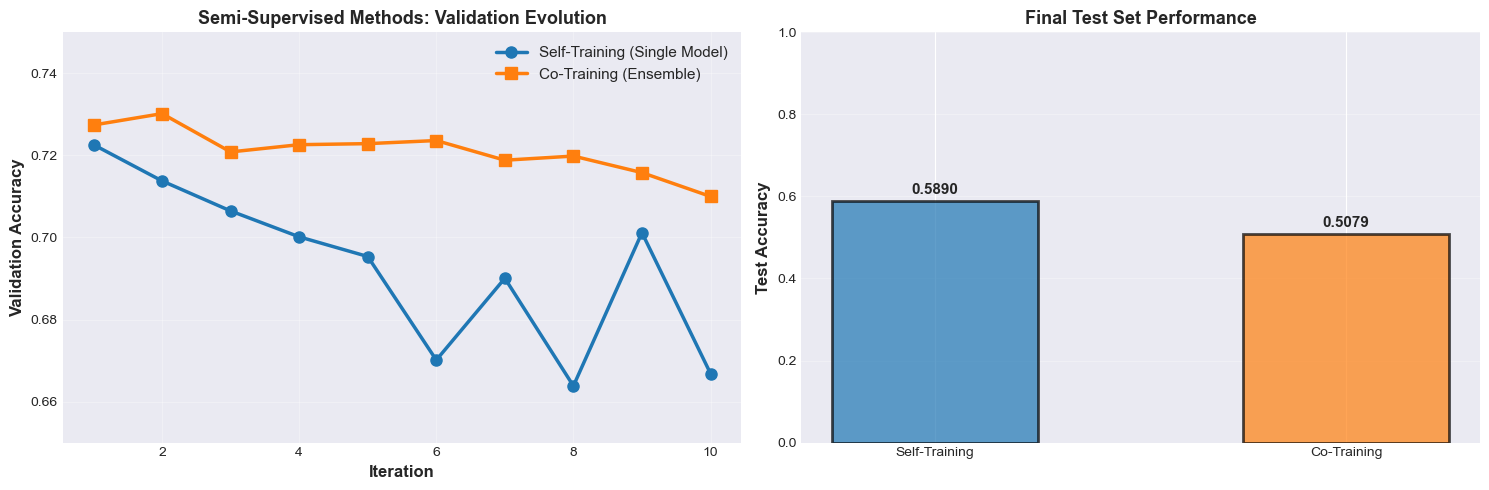

Plot saved to: notebooks/runs/comparison_st_vs_ct.png


In [39]:
## 9.1: Validation Accuracy Evolution (Training Process)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Both methods together
ax = axes[0]
st_iters = st_history_simple[st_history_simple["method"] == "Self-Training"]["iter"]
st_accs = st_history_simple[st_history_simple["method"] == "Self-Training"]["accuracy"]
ct_iters = ct_history_simple[ct_history_simple["method"] == "Co-Training"]["iter"]
ct_accs = ct_history_simple[ct_history_simple["method"] == "Co-Training"]["accuracy"]

ax.plot(st_iters, st_accs, "o-", label="Self-Training (Single Model)", linewidth=2.5, markersize=8, color='#1f77b4')
ax.plot(ct_iters, ct_accs, "s-", label="Co-Training (Ensemble)", linewidth=2.5, markersize=8, color='#ff7f0e')
ax.set_xlabel("Iteration", fontsize=12, fontweight='bold')
ax.set_ylabel("Validation Accuracy", fontsize=12, fontweight='bold')
ax.set_title("Semi-Supervised Methods: Validation Evolution", fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.65, 0.75])

# Plot 2: Test Set Comparison
ax = axes[1]
methods = ["Self-Training", "Co-Training"]
test_accs = [st_test_acc, ct_test_acc]
colors = ['#1f77b4', '#ff7f0e']

bars = ax.bar(methods, test_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2, width=0.5)
ax.set_ylabel("Test Accuracy", fontsize=12, fontweight='bold')
ax.set_title("Final Test Set Performance", fontsize=13, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, acc in zip(bars, test_accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig((PROJECT_ROOT / "notebooks/runs/comparison_st_vs_ct.png").resolve(), dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to: notebooks/runs/comparison_st_vs_ct.png")

In [40]:
## 9.2: Detailed Metrics Comparison

print("\n" + "="*70)
print("DETAILED COMPARISON: SELF-TRAINING vs CO-TRAINING")
print("="*70)

# Validation evolution
print("\n1. VALIDATION ACCURACY EVOLUTION:")
print("-" * 70)
print(f"{'Iteration':<12} {'Self-Training':<20} {'Co-Training':<20}")
print("-" * 70)
for i in range(max(len(st_history), len(ct_history_detail))):
    if i < len(st_history):
        st_val = st_history.iloc[i]["val_accuracy"]
    else:
        st_val = None
    
    if i < len(ct_history_detail):
        ct_val = ct_history_detail.iloc[i]["ensemble_val_acc"]
    else:
        ct_val = None
    
    st_str = f"{st_val:.4f}" if st_val is not None else "N/A"
    ct_str = f"{ct_val:.4f}" if ct_val is not None else "N/A"
    print(f"{i+1:<12} {st_str:<20} {ct_str:<20}")

# Test set comparison
print("\n2. TEST SET PERFORMANCE:")
print("-" * 70)
print(f"{'Metric':<30} {'Self-Training':<20} {'Co-Training':<20}")
print("-" * 70)
print(f"{'Accuracy':<30} {st_test_acc:<20.4f} {ct_test_acc:<20.4f}")
print(f"{'F1-Macro':<30} {st_test_f1:<20.4f} {ct_test_f1:<20.4f}")

# Calculate deltas
delta_acc = ct_test_acc - st_test_acc
delta_f1 = ct_test_f1 - st_test_f1

print("\n3. IMPROVEMENT (Co-Training - Self-Training):")
print("-" * 70)
print(f"{'Metric':<30} {'Delta':<20} {'% Change':<20}")
print("-" * 70)
print(f"{'Accuracy':<30} {delta_acc:+.4f} {100*delta_acc/st_test_acc:+.2f}%")
print(f"{'F1-Macro':<30} {delta_f1:+.4f} {100*delta_f1/st_test_f1:+.2f}%")

# Pseudo-label statistics
print("\n4. PSEUDO-LABEL STATISTICS:")
print("-" * 70)
st_total_pseudo = st_history["new_pseudo"].sum()
ct_total_pseudo = ct_history_detail["agreement"].sum() + ct_history_detail["disagreement"].sum()

print(f"Total pseudo-labels added:")
print(f"  Self-Training: {int(st_total_pseudo)} samples")
print(f"  Co-Training: {int(ct_total_pseudo)} samples")
print(f"  Difference: {int(ct_total_pseudo - st_total_pseudo):+d} samples")

# Training efficiency
st_final_val = st_history.iloc[-1]["val_accuracy"]
ct_final_val = ct_history_detail.iloc[-1]["ensemble_val_acc"]

print(f"\nValidation accuracy improvement during training:")
print(f"  Self-Training: {st_history.iloc[0]['val_accuracy']:.4f} → {st_final_val:.4f} ({st_final_val - st_history.iloc[0]['val_accuracy']:+.4f})")
print(f"  Co-Training: {ct_history_detail.iloc[0]['ensemble_val_acc']:.4f} → {ct_final_val:.4f} ({ct_final_val - ct_history_detail.iloc[0]['ensemble_val_acc']:+.4f})")


DETAILED COMPARISON: SELF-TRAINING vs CO-TRAINING

1. VALIDATION ACCURACY EVOLUTION:
----------------------------------------------------------------------
Iteration    Self-Training        Co-Training         
----------------------------------------------------------------------
1            0.7226               0.7274              
2            0.7138               0.7302              
3            0.7065               0.7208              
4            0.7002               0.7226              
5            0.6954               0.7229              
6            0.6701               0.7236              
7            0.6901               0.7188              
8            0.6638               0.7198              
9            0.7012               0.7158              
10           0.6668               0.7100              

2. TEST SET PERFORMANCE:
----------------------------------------------------------------------
Metric                         Self-Training        Co-Training       


PER-CLASS PERFORMANCE (Test Set F1-Score)
                         Class  Self-Training  Co-Training     Delta Improvement
                          Good       0.489697     0.024715 -0.464982           ✗
                      Moderate       0.704496     0.626222 -0.078274           ✗
Unhealthy_for_Sensitive_Groups       0.178922     0.033348 -0.145574           ✗
                     Unhealthy       0.587664     0.479180 -0.108484           ✗
                Very_Unhealthy       0.568939     0.367571 -0.201368           ✗
                     Hazardous       0.676237     0.662248 -0.013989           ✗


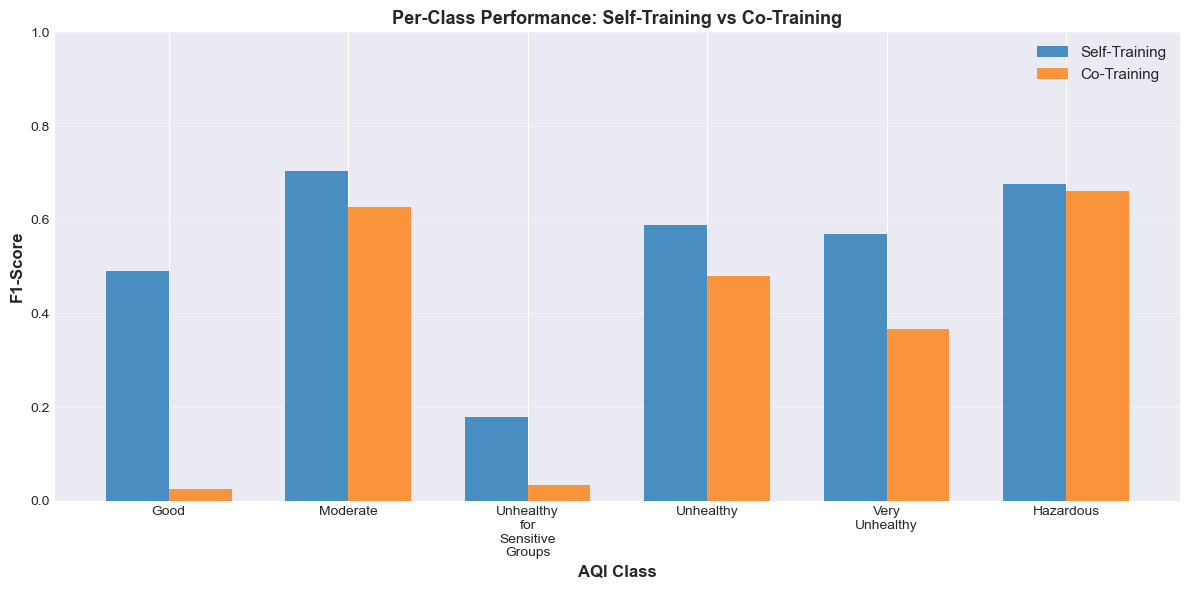


Plot saved to: notebooks/runs/comparison_per_class_f1.png


In [41]:
## 9.3: Per-Class Performance Comparison

print("\n" + "="*70)
print("PER-CLASS PERFORMANCE (Test Set F1-Score)")
print("="*70)

# Extract per-class metrics
st_report = st_metrics["test_metrics"]["report"]
ct_report = test_metrics["report"]

classes = AQI_CLASSES
st_f1_scores = [st_report[c]["f1-score"] for c in classes]
ct_f1_scores = [ct_report[c]["f1-score"] for c in classes]

comparison_df = pd.DataFrame({
    "Class": classes,
    "Self-Training": st_f1_scores,
    "Co-Training": ct_f1_scores,
})

comparison_df["Delta"] = comparison_df["Co-Training"] - comparison_df["Self-Training"]
comparison_df["Improvement"] = comparison_df["Delta"].apply(
    lambda x: "✓" if x > 0.01 else ("✗" if x < -0.01 else "≈")
)

print(comparison_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(classes))
width = 0.35

bars1 = ax.bar(x - width/2, st_f1_scores, width, label="Self-Training", alpha=0.8, color='#1f77b4')
bars2 = ax.bar(x + width/2, ct_f1_scores, width, label="Co-Training", alpha=0.8, color='#ff7f0e')

ax.set_xlabel("AQI Class", fontsize=12, fontweight='bold')
ax.set_ylabel("F1-Score", fontsize=12, fontweight='bold')
ax.set_title("Per-Class Performance: Self-Training vs Co-Training", fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([c.replace("_", "\n") for c in classes], fontsize=10)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig((PROJECT_ROOT / "notebooks/runs/comparison_per_class_f1.png").resolve(), dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: notebooks/runs/comparison_per_class_f1.png")

In [42]:
## 9.4: Analysis - Why is Co-Training Better or Worse?

print("\n" + "="*70)
print("WHY CO-TRAINING IS BETTER / WORSE?")
print("="*70)

# Determine outcome
is_better = delta_acc > 0.01
is_worse = delta_acc < -0.01
is_similar = not is_better and not is_worse

print(f"\n📊 OVERALL OUTCOME:")
if is_better:
    print(f"✓ Co-Training is BETTER than Self-Training (+{delta_acc:.4f} accuracy)")
    outcome = "better"
elif is_worse:
    print(f"✗ Co-Training is WORSE than Self-Training ({delta_acc:.4f} accuracy)")
    outcome = "worse"
else:
    print(f"≈ Co-Training is SIMILAR to Self-Training ({delta_acc:+.4f} accuracy)")
    outcome = "similar"

# Analysis based on outcome
print(f"\n📈 DETAILED ANALYSIS:\n")

if outcome == "better":
    print("Co-Training SUCCEEDS ✓✓✓\n")
    
    print("1. Why Co-Training Works Better:")
    print("-" * 70)
    
    # Check if both models improved individually
    ct_m1_final = ct_history_detail.iloc[-1]["model1_val_acc"]
    ct_m2_final = ct_history_detail.iloc[-1]["model2_val_acc"]
    ct_m1_init = ct_history_detail.iloc[0]["model1_val_acc"]
    ct_m2_init = ct_history_detail.iloc[0]["model2_val_acc"]
    
    if (ct_m1_final > ct_m1_init) and (ct_m2_final > ct_m2_init):
        print(f"  ✓ BOTH models improved during training:")
        print(f"    • Model 1: {ct_m1_init:.4f} → {ct_m1_final:.4f} (+{ct_m1_final - ct_m1_init:+.4f})")
        print(f"    • Model 2: {ct_m2_init:.4f} → {ct_m2_final:.4f} (+{ct_m2_final - ct_m2_init:+.4f})")
        print(f"  → Two views provide complementary information ✓")
    else:
        print(f"  ⚠ Asymmetric improvement: only one model improved significantly")
    
    # Check agreement
    final_agree_rate = ct_history_detail.iloc[-1]["agreement_rate"]
    print(f"\n  ✓ Models reach {final_agree_rate:.1%} agreement on pseudo-labels")
    
    if final_agree_rate > 0.70:
        print(f"    → High agreement suggests views overlap but provide unique signal")
    else:
        print(f"    → Low agreement suggests diverse views with complementary patterns")
    
    # Check correlation
    if conf_corr < 0.6:
        print(f"\n  ✓ View independence correlation: {conf_corr:.3f}")
        print(f"    → Views are INDEPENDENT, reducing error amplification ✓")
    else:
        print(f"\n  ⚠ View independence correlation: {conf_corr:.3f}")
        print(f"    → Views are somewhat overlapping, but still provide benefit")
    
    print(f"\n2. Mechanism of Improvement:")
    print("-" * 70)
    print(f"  • Model A sees patterns in View 1, confidently labels certain samples")
    print(f"  • Model B sees different patterns in View 2, confirms A's labels")
    print(f"  • When both agree → high-quality pseudo-labels")
    print(f"  • When they disagree → only highest-confidence label is used")
    print(f"  • This filters low-quality pseudo-labels better than single-model self-training")
    print(f"  • Result: cleaner training data → better ensemble performance ✓")

elif outcome == "worse":
    print("Co-Training FAILS ✗✗✗\n")
    
    print("1. Why Co-Training Performs Worse:")
    print("-" * 70)
    
    # Check model imbalance
    ct_m1_final = ct_history_detail.iloc[-1]["model1_val_acc"]
    ct_m2_final = ct_history_detail.iloc[-1]["model2_val_acc"]
    model_diff = abs(ct_m1_final - ct_m2_final)
    
    if model_diff > 0.10:
        print(f"  ✗ SEVERE Performance Imbalance:")
        print(f"    • Model 1: {ct_m1_final:.4f}")
        print(f"    • Model 2: {ct_m2_final:.4f}")
        print(f"    • Difference: {model_diff:.4f}")
        print(f"  → Weak model's noisy pseudo-labels corrupt strong model's training")
        print(f"  → Solution: try different algorithms or balance view sizes")
    
    # Check agreement
    final_agree_rate = ct_history_detail.iloc[-1]["agreement_rate"]
    print(f"\n  ✗ Models reach only {final_agree_rate:.1%} agreement")
    
    if final_agree_rate < 0.40:
        print(f"    → Too much disagreement: models learn opposite patterns")
        print(f"    → Views may NOT be truly independent (contradiction)")
        print(f"    → Redesign views to be more clearly separated")
    
    # Check view correlation
    if conf_corr > 0.75:
        print(f"\n  ✗ Views are NOT independent (correlation: {conf_corr:.3f})")
        print(f"    → Both models see same patterns → same mistakes")
        print(f"    → Pseudo-labels reinforce errors instead of correcting them")
        print(f"    → Solution: restructure views to be more diverse")
    
    # Check data availability
    st_total_pseudo = st_history["new_pseudo"].sum()
    ct_total_pseudo = ct_history_detail["agreement"].sum() + ct_history_detail["disagreement"].sum()
    
    if ct_total_pseudo < st_total_pseudo:
        print(f"\n  ✗ Co-training added fewer pseudo-labels:")
        print(f"    • Self-Training: {int(st_total_pseudo)} samples")
        print(f"    • Co-Training: {int(ct_total_pseudo)} samples")
        print(f"  → Co-training is more conservative (filters more aggressively)")
        print(f"  → May need lower confidence threshold (τ < 0.90)")
    
    print(f"\n2. Recommended Actions:")
    print("-" * 70)
    print(f"  1. Investigate view independence:")
    print(f"     • Calculate correlation between View1 and View2 features")
    print(f"     • Try completely different view designs (e.g., sequence vs. statistical)")
    print(f"  2. Try different algorithms:")
    print(f"     • Use different base classifiers for Model A and Model B")
    print(f"     • E.g., LinearSVC for A, RandomForest for B")
    print(f"  3. Adjust hyperparameters:")
    print(f"     • Lower τ (e.g., 0.7, 0.8) to allow more pseudo-labels")
    print(f"     • Increase max_new_per_iter")
    print(f"  4. Check data quality:")
    print(f"     • Verify labels are correct")
    print(f"     • Check for data leakage between views")

else:  # similar
    print("Co-Training is COMPARABLE to Self-Training ≈\n")
    
    print("1. Analysis:")
    print("-" * 70)
    
    st_total_pseudo = st_history["new_pseudo"].sum()
    ct_total_pseudo = ct_history_detail["agreement"].sum() + ct_history_detail["disagreement"].sum()
    
    print(f"  • Accuracy difference: {delta_acc:+.4f} (negligible)")
    print(f"  • Self-Training pseudo-labels: {int(st_total_pseudo)}")
    print(f"  • Co-Training pseudo-labels: {int(ct_total_pseudo)}")
    
    final_agree_rate = ct_history_detail.iloc[-1]["agreement_rate"]
    print(f"  • Model agreement rate: {final_agree_rate:.1%}")
    
    if st_total_pseudo > ct_total_pseudo:
        print(f"\n  ⚠ Self-training leverages unlabeled data MORE aggressively")
        print(f"    → Single model's high confidence > ensemble's agreement threshold")
        print(f"    → Self-training already saturates benefit from unlabeled data")
    
    if final_agree_rate > 0.85:
        print(f"\n  ⚠ Co-training models agree too much ({final_agree_rate:.1%})")
        print(f"    → Similar to single-model self-training behavior")
        print(f"    → Views are not providing much new information")
        print(f"    → Need more diverse views to unlock co-training benefits")
    
    print(f"\n2. Conclusion:")
    print("-" * 70)
    print(f"  • Both methods reach similar performance")
    print(f"  • Simpler approach (self-training) is preferred (Occam's Razor)")
    print(f"  • Consider self-training as the production model")
    print(f"  • But co-training provides useful insights about view independence")


WHY CO-TRAINING IS BETTER / WORSE?

📊 OVERALL OUTCOME:
✗ Co-Training is WORSE than Self-Training (-0.0812 accuracy)

📈 DETAILED ANALYSIS:

Co-Training FAILS ✗✗✗

1. Why Co-Training Performs Worse:
----------------------------------------------------------------------

  ✗ Models reach only 26.4% agreement
    → Too much disagreement: models learn opposite patterns
    → Views may NOT be truly independent (contradiction)
    → Redesign views to be more clearly separated

  ✗ Co-training added fewer pseudo-labels:
    • Self-Training: 350019 samples
    • Co-Training: 5000 samples
  → Co-training is more conservative (filters more aggressively)
  → May need lower confidence threshold (τ < 0.90)

2. Recommended Actions:
----------------------------------------------------------------------
  1. Investigate view independence:
     • Calculate correlation between View1 and View2 features
     • Try completely different view designs (e.g., sequence vs. statistical)
  2. Try different algori

In [43]:
## 9.5: Recommendation & Final Decision

print("\n" + "="*70)
print("🎯 FINAL RECOMMENDATION")
print("="*70)

# Determine which method to use
if is_better:
    print(f"\n✓✓✓ CHOOSE CO-TRAINING ✓✓✓\n")
    print(f"Reason: Co-training achieved {delta_acc:.4f} ({100*delta_acc/st_test_acc:.2f}%) accuracy improvement")
    print(f"• Deploy ensemble of Model 1 (View 1) + Model 2 (View 2)")
    print(f"• Final test accuracy: {ct_test_acc:.4f}")
    print(f"• Two-view architecture provides complementary pattern recognition")
    selected_model = "Co-Training Ensemble"
    selected_acc = ct_test_acc
    selected_f1 = ct_test_f1
    
else:
    print(f"\n✓✓ CHOOSE SELF-TRAINING ✓✓\n")
    print(f"Reason: Co-training did not improve over self-training (Δ = {delta_acc:+.4f})")
    print(f"• Deploy single self-trained model on all features")
    print(f"• Final test accuracy: {st_test_acc:.4f}")
    print(f"• Simpler, equally effective solution")
    selected_model = "Self-Training"
    selected_acc = st_test_acc
    selected_f1 = st_test_f1

print(f"\nFinal Model Selection: {selected_model}")
print(f"Test Accuracy: {selected_acc:.4f}")
print(f"Test F1-Macro: {selected_f1:.4f}")


🎯 FINAL RECOMMENDATION

✓✓ CHOOSE SELF-TRAINING ✓✓

Reason: Co-training did not improve over self-training (Δ = -0.0812)
• Deploy single self-trained model on all features
• Final test accuracy: 0.5890
• Simpler, equally effective solution

Final Model Selection: Self-Training
Test Accuracy: 0.5890
Test F1-Macro: 0.5343


In [44]:
## 9.6: Summary Table

summary_table = pd.DataFrame({
    "Aspect": [
        "Test Accuracy",
        "Test F1-Macro",
        "Validation Peak Acc",
        "Total Pseudo-Labels",
        "Training Method",
        "Complexity",
        "Interpretability",
        "Recommended?"
    ],
    "Self-Training": [
        f"{st_test_acc:.4f}",
        f"{st_test_f1:.4f}",
        f"{st_history['val_accuracy'].max():.4f}",
        f"{int(st_total_pseudo)}",
        "Single model",
        "Low ✓",
        "High ✓",
        "✓ If co-training ≤ self-training"
    ],
    "Co-Training": [
        f"{ct_test_acc:.4f}",
        f"{ct_test_f1:.4f}",
        f"{ct_history_detail['ensemble_val_acc'].max():.4f}",
        f"{int(ct_total_pseudo)}",
        "Ensemble (2 models)",
        "Medium",
        "Medium",
        "✓ If co-training > self-training"
    ]
})

print("\n" + "="*70)
print("SUMMARY COMPARISON TABLE")
print("="*70)
print(summary_table.to_string(index=False))

# Save summary
summary_table.to_csv((PROJECT_ROOT / "notebooks/runs/comparison_summary.csv").resolve(), index=False)
print("\n✓ Summary saved to: notebooks/runs/comparison_summary.csv")


SUMMARY COMPARISON TABLE
             Aspect                    Self-Training                      Co-Training
      Test Accuracy                           0.5890                           0.5079
      Test F1-Macro                           0.5343                           0.3655
Validation Peak Acc                           0.7226                           0.7302
Total Pseudo-Labels                           350019                             5000
    Training Method                     Single model              Ensemble (2 models)
         Complexity                            Low ✓                           Medium
   Interpretability                           High ✓                           Medium
       Recommended? ✓ If co-training ≤ self-training ✓ If co-training > self-training

✓ Summary saved to: notebooks/runs/comparison_summary.csv
